### import libary

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers, models
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D

import cal_def

### make data for train , test

In [2]:
scale = MinMaxScaler(feature_range=(0, 1))

def sklearn_scaled(data, feature):
    # scale = MinMaxScaler(feature_range=(0, 1))
    for i in feature:
        data[i] = scale.fit_transform(data[i].values.reshape(-1, 1))
    return data

def split_data(data, data_range, train_ratio=0.8):
    split_range = int(len(data) * train_ratio)

    # features = [
    #     "RSI", "SMA_30", "SMA_120", "BB_upper", "SMA_210"
    #     "BB_middle", "BB_lower", "ADOSC", "close_price"
    # ]
    # features = [
    #     'SMA_30', 'SMA_120', 'SMA_210', 'RSI', 'MACD', 'MACD_Signal',
    #     'BB_upper', 'BB_middle', 'BB_lower', 'Momentum', 'Volatility', 'Stochastic',
    #     "ADOSC", "OBV", "AD"
    # ]
    # ต้นแบบ
    features = [
        'SMA_30', 'SMA_120', 'BB_upper', 'BB_middle', 'BB_lower',
        "AD", 'Volatility', "close_price", "high_price", "low_price",
        "open_price",
    ]
    # เพิ่ม SMA_210 ทำให้ดีขึ้นหวาเดิม
    features = [
        'SMA_30', 'SMA_120', "SMA_210", 'BB_upper', 'BB_middle', 'BB_lower',
        "AD", 'Volatility', "close_price", "high_price", "low_price",
        "open_price",
    ]
    # # ลองตัด 'BB_upper', 'BB_middle', 'BB_lower', ก็ดูดี
    # features = [
    #     'SMA_30', 'SMA_120', "SMA_210",
    #     "AD", 'Volatility', "close_price", "high_price", "low_price",
    #     "open_price", "OBV",
    # ]
    # # # ไม่เวิก
    # features = [
    #     'SMA_30', 'SMA_120', "SMA_210",
    #     "close_price", "high_price", "low_price",
    #     "open_price",
    # ]
    # # ลองตัด 'OBV', 'Volatility' ไม่ค่อยเวิก
    # features = [
    #     'SMA_30', 'SMA_120', "SMA_210",
    #     "AD", "close_price", "high_price", "low_price",
    #     "open_price",
    # ]
    # # ลองตัด 'OBV' ยังไม่แน่ใจ
    # features = [
    #     'SMA_30', 'SMA_120', "SMA_210",
    #     "AD", 'Volatility', "close_price", "high_price", "low_price",
    #     "open_price",
    # ]
    # # ลองเพิ่ม sma500 ไม่เวิก
    # features = [
    #     'SMA_30', 'SMA_120', "SMA_210", "SMA_500",
    #     "AD", 'Volatility', "close_price", "high_price", "low_price",
    #     "open_price",
    # ]
    data = sklearn_scaled(data, features)
    tmp = data["Target"].tolist()
    data = sklearn_scaled(data, ["Target"])
    pre_close = data["Close"]["GC=F"].to_numpy()
    pre_close = (pre_close - min(tmp)) / (max(tmp) - min(tmp))

    pre_x_train = data.iloc[:split_range].loc[:,features]
    pre_y_train = data.iloc[:split_range].loc[:,["Target"]]
    pre_x_test = data.iloc[split_range:].loc[:,features]
    pre_y_test = data.iloc[split_range:].loc[:,["Target"]]
    train_pre_date = data.iloc[:split_range].index.to_list()
    pre_date = data.iloc[split_range:].index.to_list()
    pre_close = pre_close[split_range:]
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    date = []
    train_close = []
    close = []
    for i in range(len(pre_x_train)-data_range):
        # x_tmp = np.transpose(pre_x_train.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_train.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_train.iloc[i+data_range-1].to_numpy()
        x_train.append(x_tmp)
        y_train.append(y_tmp)
        train_close.append(train_pre_date[i+data_range-1])

    for i in range(len(pre_x_test)-data_range):
        # x_tmp = np.transpose(pre_x_test.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_test.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_test.iloc[i+data_range-1].to_numpy()
        x_test.append(x_tmp)
        y_test.append(y_tmp)
        date.append(pre_date[i+data_range-1])
        close.append(pre_close[i+data_range-1])
    x_train = np.array(x_train)
    y_train = np.array(y_train).reshape(-1)
    x_test = np.array(x_test)
    y_test = np.array(y_test).reshape(-1)
    # close = np.array(close)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, len(date), len(close))
    return x_train, y_train, x_test, y_test, date, close

def prepar_data(asset, start, end, target_date):
    data = yf.download(asset, start=start, end=end)
    data.dropna(inplace=True)

    # # momentum indicator
    # data['RSI'] = ta.RSI(data['Close'][asset[0]], timeperiod=14)
    # data['MACD'], data['MACD_Signal'], _ = ta.MACD(data['Close'][asset[0]], fastperiod=12, slowperiod=26, signalperiod=9)
    # data['Momentum'] = ta.MOM(data['Close'][asset[0]], timeperiod=14)
    # data['Stochastic'] = ta.STOCH(data['High'][asset[0]], data['Low'][asset[0]], data['Close'][asset[0]], fastk_period=14, slowk_period=3)[0]

    # volatility indicator
    data['Volatility'] = ta.ATR(data['High'][asset[0]], data['Low'][asset[0]], data['Close'][asset[0]], timeperiod=14)
    data["NATR"] = ta.NATR(data['High'][asset[0]], data['Low'][asset[0]], data['Close'][asset[0]], timeperiod=14)

    # overlap studies functions
    data['SMA_30'] = ta.MA(data['Close'][asset[0]], timeperiod=30)
    data['SMA_120'] = ta.MA(data['Close'][asset[0]], timeperiod=100)
    data['SMA_210'] = ta.MA(data['Close'][asset[0]], timeperiod=250)
    # data['SMA_500'] = ta.MA(data['Close'][asset[0]], timeperiod=500)
    data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['Close'][asset[0]], timeperiod=20)
    
    # volume indicator
    data["AD"] = ta.AD(data["High"][asset[1]], data["Low"][asset[1]], data["Close"][asset[1]], data["Volume"][asset[1]])
    data["ADOSC"] = ta.ADOSC(data["High"][asset[1]], data["Low"][asset[1]], data["Close"][asset[1]], data["Volume"][asset[1]], fastperiod=3, slowperiod=10)
    data["OBV"] = ta.OBV(data["Close"][asset[1]], data["Volume"][asset[1]])
    data["close_price"] = data["Close"][asset[0]]
    data["high_price"] = data["High"][asset[0]]
    data["low_price"] = data["Low"][asset[0]]
    data["open_price"] = data["Open"][asset[0]]

    # target of predict
    data["Target"] = data["Close"][asset[0]].shift(-target_date)

    data.dropna(inplace=True)
    return data

def model_lstm(range_input=30, neurons=16, n_feature=3):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(range_input, n_feature)))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
    return model

def cnn_lstm(row, col):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(row, col)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=128, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
import seaborn as sb
data = prepar_data(["GC=F", "ITA"], '2014-01-01', '2024-12-01', 1)
# features = [
#         "SMA_30", "SMA_120", "BB_upper",
#         "BB_middle", "BB_lower", "AD", "ADOSC", "OBV",
#     ]
plt.figure(figsize=(20, 15))
sb.heatmap(data.corr(), annot=True)
plt.show()
# x_train, y_train, x_test, y_test, date, close = split_data(data.copy(), data_range=30, train_ratio=0.5)
# # i = features[4]
# # for i in features:
# #     plt.plot(data[i], label = i)
# plt.plot(data["ADOSC"], label = "ADOSC")
# plt.plot(data["MACD_Signal"], label = "MACD_Signal")
# plt.legend()
# plt.show()

In [94]:
pct = data.loc[date]["Close"]["GC=F"].pct_change().cumsum()

# -----------------------------------------------------------------------------------

[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  2 of 2 completed


(1214, 30, 12) (1214,) (1214, 30, 12) (1214,) 1214 1214


d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


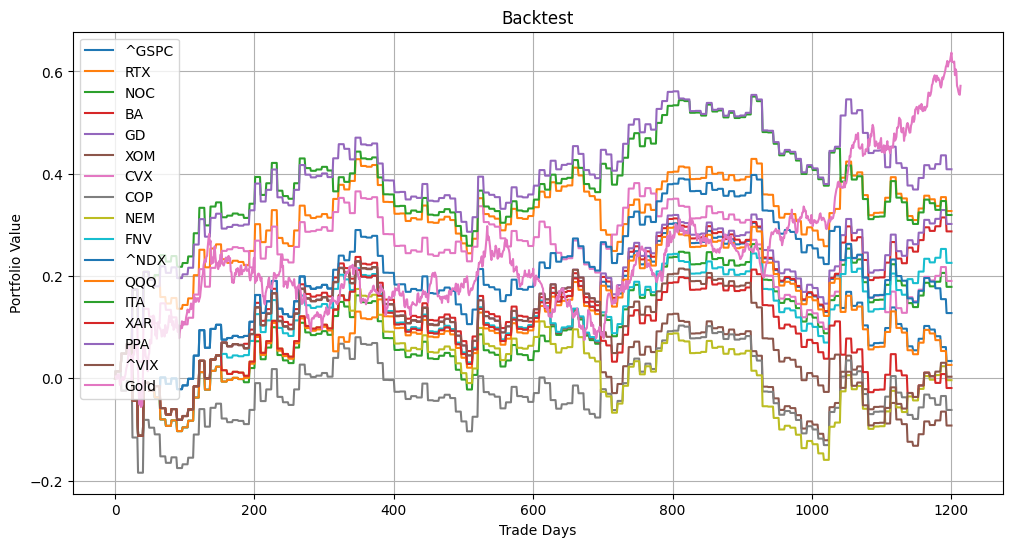

In [14]:
plt.figure(figsize=(12, 6))
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value')
plt.grid(True)

finances = []

vol = ["^GSPC","RTX","NOC","BA","GD","XOM","CVX","COP","NEM","FNV","^NDX","QQQ","ITA","XAR","PPA","^VIX",]
# vol = ["^GSPC"]
predict_models = []
train_predict = []
real_actions = []
my_actions = []
for v in vol:
    finance = []
    real_action = []
    my_action = []
    asset = ["GC=F", v]
    taget_date = 7
    data = prepar_data(asset, '2014-01-01', '2024-12-01', taget_date)
    x_train, y_train, x_test, y_test, date, close = split_data(data.copy(), data_range=30, train_ratio=0.5)

    model = model_lstm(range_input=x_train.shape[1], n_feature=x_train.shape[2], neurons=128)
    # model = cnn_lstm(x_train.shape[1], x_train.shape[2])
    history = model.fit(x_train, y_train, batch_size=200, epochs=60, verbose=0)
    # history = model.fit(x_train, y_train, batch_size=200, epochs=60, verbose=0)
    train_predict.append(model.predict(x_train))
    scale_predict = model.predict(x_test)
    predict_models.append(scale_predict)

    capital = 10
    capital_history = [capital]
    open_status = False

    count_day = 0

    for i in range(taget_date, len(scale_predict) - taget_date):
        today_price = data["Close"]["GC=F"].loc[date[i]]
        future_price = data["Close"]["GC=F"].loc[date[i + taget_date]]
        # day_change = (scale_predict[i] - close[i])
        day_change = (scale_predict[i] - scale_predict[i-taget_date])
        if open_status:
            count_day += 1
            if count_day == taget_date:
                open_status = False
        elif abs(day_change) > 0.0:
            open_status = True
            count_day = 0
            capital *= 0.999
            if day_change > 0:
                profit = (future_price - today_price) / today_price * capital
                my_action.append(1)
            else:
                profit = (today_price - future_price) / today_price * capital
                my_action.append(0)
            # profit_list.append(profit+profit_list[-1])
            capital += profit
            capital *= 0.999
            if future_price > today_price:
                real_action.append(1)
            else:
                real_action.append(0)
        
        capital_history.append(capital)
    my_actions.append(my_action)
    real_actions.append(real_action)
    finance = [v, cal_def.cal_cagr(capital_history), cal_def.cal_max_drawdown(capital_history)[0], cal_def.cal_sd(capital_history)*np.sqrt(20)]
    finances.append(finance)
    profit = [0]
    for i in range(len(capital_history) - 1):
        profit.append((capital_history[i+1]-capital_history[i])/capital_history[i] + profit[-1])
    plt.plot(profit, label=v)
pct = data.loc[date]["Close"]["GC=F"].pct_change().cumsum().to_list()
plt.plot(pct, label="Gold")
plt.legend()
plt.show()

In [12]:
for i in finances:
    print(i)

['^GSPC', 0.0072628232291147565, 0.1882563661001869, 3.8505221967620584]
['RTX', 0.07457243673066039, 0.1710125691202867, 5.402930771855025]
['NOC', -0.02051517297819383, 0.255028305365685, 3.116737462196565]
['BA', 0.02301548038198642, 0.21879254240371962, 3.5379526800111956]
['GD', -0.020910301979044643, 0.1882563661001869, 2.5489543875257894]
['XOM', 0.010022254813549125, 0.21366181187316813, 3.7879302111851185]
['CVX', -0.02176297896568702, 0.31861627916555124, 4.133620623166165]
['COP', -0.02202814670646358, 0.3249247992464174, 4.7639790982107595]
['NEM', -0.004135359386071236, 0.20699275189530353, 2.99772712736918]
['FNV', 0.010252075527257487, 0.1882563661001869, 2.7025173389263397]
['^NDX', 0.01913023066437214, 0.23033634164322758, 5.068268717287543]
['QQQ', 0.0077711569257403745, 0.1882563661001869, 3.3777636736271406]
['ITA', 0.06271037304903015, 0.16932258779117218, 5.137494401900396]
['XAR', 0.004787443898336408, 0.1882563661001869, 3.1989232023919856]
['PPA', 0.06596818310

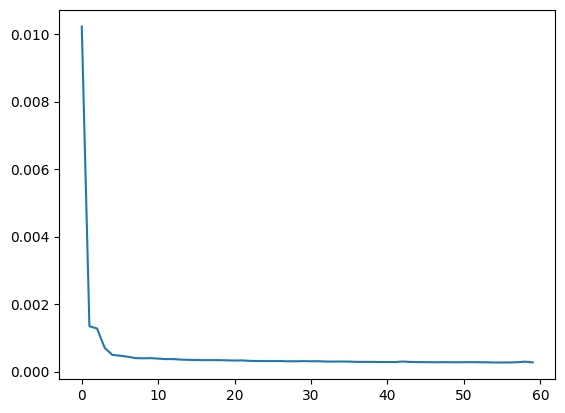

In [13]:
plt.plot(history.history["loss"])

In [17]:
keep = predict_models

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
for i in range(len(vol)):
    accuracy = accuracy_score(real_actions[i], my_actions[i])
    precision = precision_score(real_actions[i], my_actions[i])
    recall = recall_score(real_actions[i], my_actions[i])
    f1 = f1_score(real_actions[i], my_actions[i])
    print(vol[i], accuracy, precision, recall, f1)

^GSPC 0.5133333333333333 0.55 0.5432098765432098 0.546583850931677
RTX 0.52 0.5569620253164557 0.5432098765432098 0.55
NOC 0.5266666666666666 0.5641025641025641 0.5432098765432098 0.5534591194968553
BA 0.56 0.5824175824175825 0.654320987654321 0.6162790697674418
GD 0.5333333333333333 0.569620253164557 0.5555555555555556 0.5625
XOM 0.5466666666666666 0.5714285714285714 0.6419753086419753 0.6046511627906976
CVX 0.5066666666666667 0.5411764705882353 0.5679012345679012 0.5542168674698795
COP 0.47333333333333333 0.5121951219512195 0.5185185185185185 0.5153374233128835
NEM 0.5266666666666666 0.5595238095238095 0.5802469135802469 0.5696969696969697
FNV 0.52 0.5542168674698795 0.5679012345679012 0.5609756097560976
^NDX 0.4866666666666667 0.5263157894736842 0.49382716049382713 0.5095541401273885
QQQ 0.5133333333333333 0.55 0.5432098765432098 0.546583850931677
ITA 0.5266666666666666 0.5625 0.5555555555555556 0.5590062111801242
XAR 0.5266666666666666 0.5595238095238095 0.5802469135802469 0.569696

class ตอนท้าย

In [6]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def svm_model(tr, cl_tr, te, cl_te):
    model = SVC(kernel='linear')  # สามารถเลือก kernel อื่นๆ เช่น 'rbf', 'poly'
    model.fit(tr, cl_tr)

    # ทำนายผลและคำนวณความแม่นยำ
    y_pred = model.predict(te)
    accuracy = accuracy_score(cl_te, y_pred)
    precision = precision_score(cl_te, y_pred)
    recall = recall_score(cl_te, y_pred)
    f1 = f1_score(cl_te, y_pred)

    # แสดงผลลัพธ์
    print(f"SVM Test Accuracy: {accuracy:.4f} {precision:.4f} {recall:.4f} {f1:.4f}")
    # print(f"Test Accuracy: {accuracy:.4f}")
    # print(f"Precision: {precision:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"F1-score: {f1:.4f}")
    return model

def RM_model(tr, cl_tr, te, cl_te):
    model = RandomForestClassifier(n_estimators=200, random_state=42)  # สามารถเลือก kernel อื่นๆ เช่น 'rbf', 'poly'
    model.fit(tr, cl_tr)

    # ทำนายผลและคำนวณความแม่นยำ
    y_pred = model.predict(te)
    accuracy = accuracy_score(cl_te, y_pred)
    precision = precision_score(cl_te, y_pred)
    recall = recall_score(cl_te, y_pred)
    f1 = f1_score(cl_te, y_pred)

    # แสดงผลลัพธ์
    print(f"RM Test Accuracy: {accuracy:.4f} {precision:.4f} {recall:.4f} {f1:.4f}")
    # print(f"Test Accuracy: {accuracy:.4f}")
    # print(f"Precision: {precision:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"F1-score: {f1:.4f}")
    return model

def k_NN(tr, cl_tr, te, cl_te):
    # สร้างและฝึก k-NN
    model = KNeighborsClassifier(n_neighbors=10)
    model.fit(tr, cl_tr)

    # ทำนายผลและคำนวณความแม่นยำ
    y_pred = model.predict(te)
    accuracy = accuracy_score(cl_te, y_pred)
    precision = precision_score(cl_te, y_pred)
    recall = recall_score(cl_te, y_pred)
    f1 = f1_score(cl_te, y_pred)

    # แสดงผลลัพธ์
    print(f"KNN Test Accuracy: {accuracy:.4f} {precision:.4f} {recall:.4f} {f1:.4f}")
    # print(f"Test Accuracy: {accuracy:.4f}")
    # print(f"Precision: {precision:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"F1-score: {f1:.4f}")
    return model

In [7]:
def back_test_class(model, scale_predict, v):
    capital = 10
    capital_history = [capital]
    open_status = False

    count_day = 0

    for i in range(taget_date, len(scale_predict) - taget_date):
        today_price = data["Close"]["GC=F"].loc[date[i]]
        future_price = data["Close"]["GC=F"].loc[date[i + taget_date]]
        # day_change = (scale_predict[i] - close[i])
        day_change = model.predict(scale_predict[i - taget_date:i].flatten().reshape(1, -1))
        if open_status:
            count_day += 1
            if count_day == taget_date:
                open_status = False
        elif abs(day_change) > 0.0:
            open_status = True
            count_day = 0
            capital *= 0.999
            if day_change == 1:
                profit = (future_price - today_price) / today_price * capital
            else:
                profit = (today_price - future_price) / today_price * capital
            # profit_list.append(profit+profit_list[-1])
            capital += profit
            capital *= 0.999
        
        capital_history.append(capital)
    finance = [v, cal_def.cal_cagr(capital_history), cal_def.cal_max_drawdown(capital_history)[0], cal_def.cal_sd(capital_history)*np.sqrt(20)]
    print(finance)
    # finances.append(finance)
    profit = [0]
    for i in range(len(capital_history) - 1):
        profit.append((capital_history[i+1]-capital_history[i])/capital_history[i] + profit[-1])
    plt.plot(profit, label=v)
    # plt.legend()

In [8]:
def get_class(predict, target, y):
    train_data = []
    class_data = []
    for i in range(target, len(predict)):
        train_data.append(np.array(predict[i - target:i]).flatten())
        if y[i-1] > y[i-target]:
            class_data.append(1)
        else:
            class_data.append(0)
    return np.array(train_data), np.array(class_data)

^GSPC
SVM Test Accuracy: 0.5526 0.5526 1.0000 0.7118
['^GSPC', 0.027805046019180324, 0.3388648389235546, 3.7923731093644752]
RM Test Accuracy: 0.5510 0.5519 0.9970 0.7105
['^GSPC', 0.027805046019180324, 0.3388648389235546, 3.7923731093644752]
KNN Test Accuracy: 0.5186 0.5726 0.5082 0.5385
['^GSPC', -0.014856066443815985, 0.2670528733253929, 2.8586644973607935]
----------
RTX
SVM Test Accuracy: 0.5526 0.5526 1.0000 0.7118
['RTX', 0.027805046019180324, 0.3388648389235546, 3.7923731093644752]
RM Test Accuracy: 0.5518 0.5524 0.9955 0.7105
['RTX', 0.027805046019180324, 0.3388648389235546, 3.7923731093644752]
KNN Test Accuracy: 0.4706 0.6795 0.0795 0.1423
['RTX', 0.01762759187192664, 0.11009980284494728, 1.3271437099957768]
----------
NOC
SVM Test Accuracy: 0.5526 0.5526 1.0000 0.7118
['NOC', 0.027805046019180324, 0.3388648389235546, 3.7923731093644752]
RM Test Accuracy: 0.5510 0.5521 0.9925 0.7095
['NOC', -0.01640878425649761, 0.342085766464163, 3.712113753939726]
KNN Test Accuracy: 0.4573 

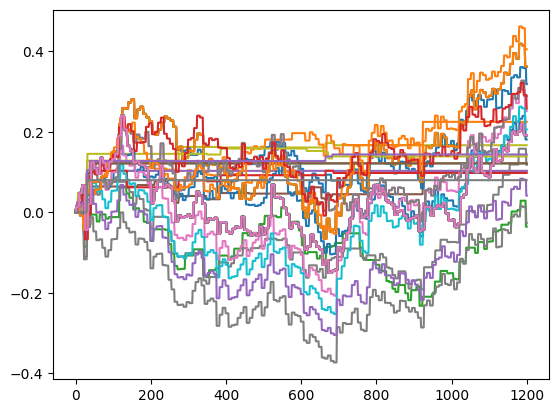

In [9]:
taget_date = 7
for i in range(len(vol)):
    # if vol[i] == "QQQ" or vol[i] == "RTX":
    print(vol[i])
    train_data, train_class_data = get_class(train_predict[i], taget_date, y_train)
    test_data, test_class_data = get_class(predict_models[i], taget_date, y_test)
    svm_m = svm_model(train_data, train_class_data, test_data, test_class_data)
    back_test_class(svm_m, predict_models[i], vol[i])
    # print()
    rm_m = RM_model(train_data, train_class_data, test_data, test_class_data)
    back_test_class(rm_m, predict_models[i], vol[i])
    # print()
    knn_m = k_NN(train_data, train_class_data, test_data, test_class_data)
    back_test_class(knn_m, predict_models[i], vol[i])
    print("-"*10)
        # print(train_data[0:2], train_class_data[0])
        # print(test_data[:2], test_class_data[0])

    # break
# print(y_train[:10])

จูน

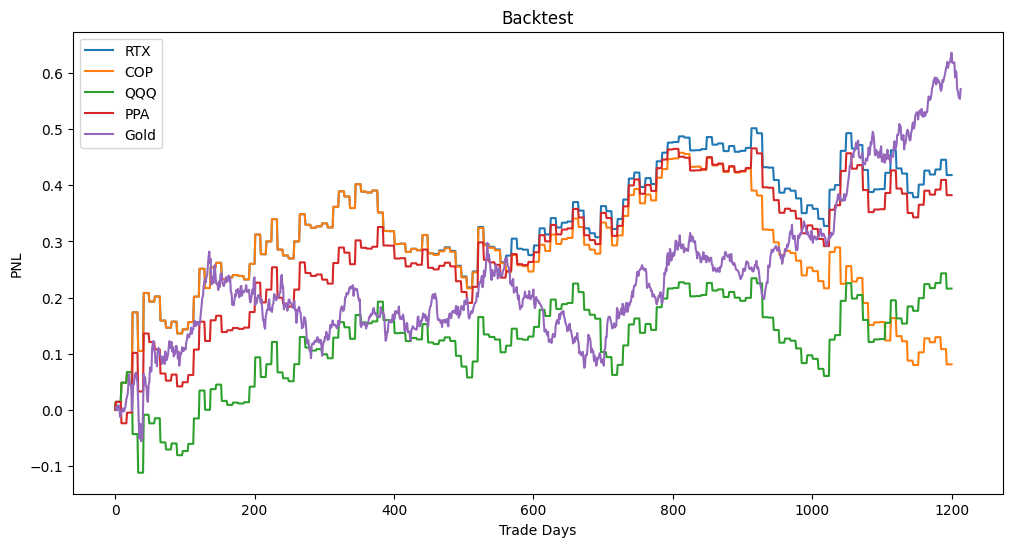

  volume_asset      CAGR  Max Drawdown        SD
0          RTX  0.077672      0.171013  0.261692
1          COP  0.004349      0.324925  0.256784
2          QQQ  0.032901      0.171809  0.202585
3          PPA  0.069635      0.163215  0.301208


In [31]:
# predict_models
plt.figure(figsize=(12, 6))
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('PNL')

finances = []
for s, v in zip(predict_models, vol):
    scale_predict = s
    capital = 10
    capital_history = [capital]
    open_status = False

    count_day = 0
    if not(v == "RTX" or v == "PPA" or v == "QQQ" or v == "COP"):
        continue
    for i in range(taget_date, len(scale_predict) - taget_date):
        today_price = data["Close"]["GC=F"].loc[date[i]]
        future_price = data["Close"]["GC=F"].loc[date[i + taget_date]]
        # day_change = (scale_predict[i] - close[i])
        day_change = (scale_predict[i] - scale_predict[i-taget_date])
        if open_status:
            count_day += 1
            if count_day == taget_date:
                open_status = False
        elif abs(day_change) > 0.0:
            open_status = True
            count_day = 0
            capital *= 0.999
            if day_change > 0:
                profit = (future_price - today_price) / today_price * capital
            else:
                profit = (today_price - future_price) / today_price * capital
            # profit_list.append(profit+profit_list[-1])
            capital += profit
            capital *= 0.999
        
        capital_history.append(capital)
    # finance = [v, cal_def.cal_cagr(capital_history), cal_def.cal_max_drawdown(capital_history)[0], cal_def.cal_sd(capital_history)*np.sqrt(250)]
    # finances.append(finance)
    profit = [0]
    for i in range(len(capital_history) - 1):
        profit.append((capital_history[i+1]-capital_history[i])/capital_history[i] + profit[-1])
    finance = [v, cal_def.cal_cagr(capital_history), cal_def.cal_max_drawdown(capital_history)[0], cal_def.cal_sd(profit)*np.sqrt(250)]
    finances.append(finance)
    plt.plot(profit, label=v)
    
pct = data.loc[date]["Close"]["GC=F"].pct_change().cumsum().to_list()
plt.plot(pct, label="Gold")
plt.legend()
plt.show()
df = pd.DataFrame(finances, columns=["volume_asset", "CAGR", "Max Drawdown", "SD"])
print(df)

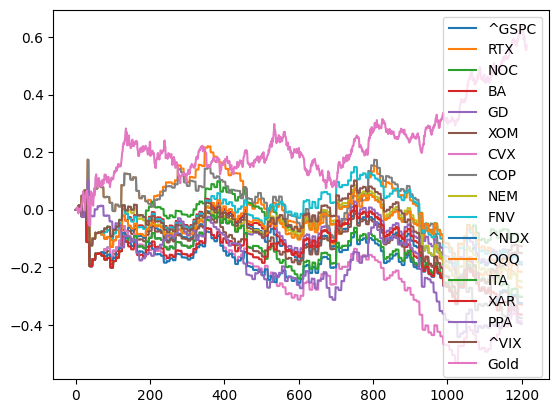

In [15]:
# predict_models
finances = []
status = 0
open_price = 0
cut_loss = 0.1
for s, v in zip(predict_models, vol):
    scale_predict = s
    capital = 10
    capital_history = [capital]
    open_status = False

    count_day = 0
    # if not(v == "QQQ" or v == "RTX"):
    #     continue
    for i in range(taget_date, len(scale_predict) - taget_date):
        today_price = data["Close"]["GC=F"].loc[date[i]]
        # future_price = data["Close"]["GC=F"].loc[date[i + taget_date]]
        # day_change = (scale_predict[i] - close[i])
        day_change = (scale_predict[i] - scale_predict[i-taget_date])
        if open_status:
            count_day += 1
            if status == 1 and (today_price - open_price) / open_price < -cut_loss:
                open_status = False
                profit = (today_price - open_price) / open_price * capital
                capital += profit
                capital *= 0.999
            elif status == 2 and (today_price - open_price) / open_price > cut_loss:
                open_status = False
                profit = (open_price - today_price) / open_price * capital
                capital += profit
                capital *= 0.999
            elif count_day == taget_date:
                open_status = False
                if status == 1:
                    profit = (today_price - open_price) / open_price * capital
                else:
                    profit = (open_price - today_price) / open_price * capital
                capital += profit
                capital *= 0.999
        elif abs(day_change) > 0.0:
            open_status = True
            count_day = 0
            open_price = today_price
            if day_change > 0:
                status = 1
            else:
                status = 2
            capital *= 0.999
        
        capital_history.append(capital)
    finance = [v, cal_def.cal_cagr(capital_history), cal_def.cal_max_drawdown(capital_history)[0], cal_def.cal_sd(capital_history)*np.sqrt(20)]
    finances.append(finance)
    profit = [0]
    for i in range(len(capital_history) - 1):
        profit.append((capital_history[i+1]-capital_history[i])/capital_history[i] + profit[-1])
    plt.plot(profit, label=v)
pct = data.loc[date]["Close"]["GC=F"].pct_change().cumsum().to_list()
plt.plot(pct, label="Gold")
plt.legend()
plt.show()

In [14]:
df = pd.DataFrame(finances, columns=["asset", "CAGR", "Max Drawdown", "SD"])
print(df)

    asset      CAGR  Max Drawdown        SD
0   ^GSPC -0.133903      0.505604  4.393032
1     RTX -0.066963      0.409471  5.581716
2     NOC -0.092754      0.436250  4.087924
3      BA -0.046262      0.361992  4.832997
4      GD -0.100944      0.431258  4.300851
5     XOM -0.052446      0.349768  4.227796
6     CVX -0.116400      0.476752  5.263008
7     COP -0.087460      0.455091  5.976137
8     NEM -0.094521      0.427218  4.648794
9     FNV -0.094464      0.427047  4.646872
10   ^NDX -0.110365      0.445491  4.152080
11    QQQ -0.089228      0.402608  3.987876
12    ITA -0.160100      0.573426  5.053844
13    XAR -0.111595      0.441361  4.898299
14    PPA -0.091152      0.447609  4.790564
15   ^VIX -0.085833      0.415289  4.530892


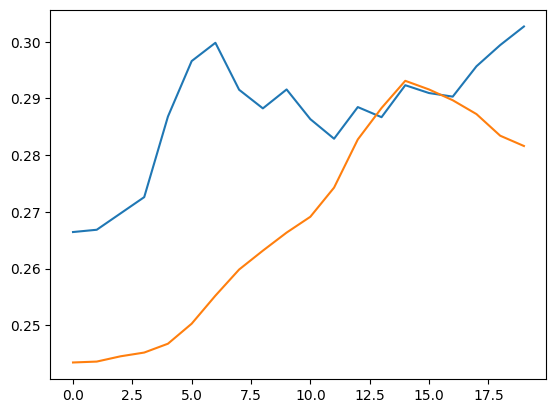

In [36]:
plt.plot(y_test[:20])
plt.plot(scale_predict[:20])

In [22]:
asset = ["GC=F", "^GSPC"]
taget_date = 7
data = prepar_data(asset, '2014-01-01', '2024-12-01', taget_date)
# data = prepar_data(["GC=F"], '2014-01-01', '2024-12-01')
data.shape

[*********************100%***********************]  2 of 2 completed


(2648, 29)

In [23]:
x_train, y_train, x_test, y_test, date, close = split_data(data.copy(), data_range=30, train_ratio=0.5)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, len(date))

(1294, 30, 15) (1294,) (1294, 30, 15) (1294,) 1294 1294
(1294, 30, 15) (1294,) (1294, 30, 15) (1294,) 1294


### train model

ทดเผื่อเปลี่ยน activation

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0113
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0016
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.0471e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 4.2934e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 3.7861e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.0997e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.7198e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.0152e-04
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.6390e-04
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 2.6008e-04
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2.7132e-04
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 2.4530e-04
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 2.4682e-04
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 2.5220e-04
Epoch 15/50
13/13 ━━━━━

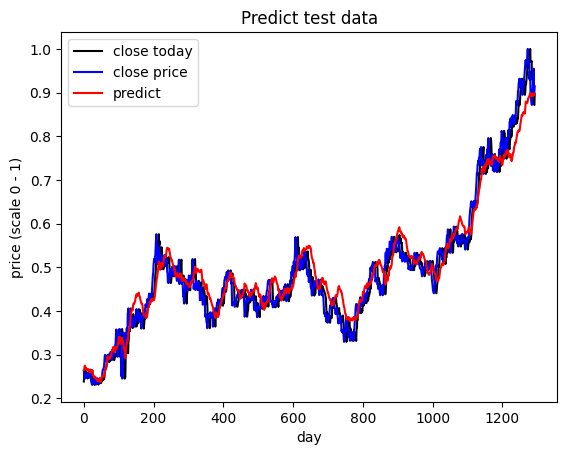

In [26]:
def model_lstm(range_input=30, neurons=16, n_feature=3):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(range_input, n_feature)))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
    return model

model = model_lstm(range_input=x_train.shape[1], n_feature=x_train.shape[2], neurons=200)
history = model.fit(x_train, y_train, batch_size=100, epochs=50)

# plt.plot(history.history["loss"])
scale_predict = model.predict(x_test)
plt.plot(close, c="k", label="close today")
plt.plot(y_test, c="b", label="close price")
plt.plot(scale_predict, c="r", label="predict")
plt.title("Predict test data")
plt.xlabel("day")
plt.ylabel("price (scale 0 - 1)")
plt.legend()

mse = np.mean((y_test-scale_predict.flatten())**2)
rmse = np.sqrt(mse)
mae = np.mean(abs(y_test-scale_predict.flatten()))
print(mse)
print(rmse)
print(mae)

In [ ]:
# model = models.load_model("model/lstm_36n_.h5")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


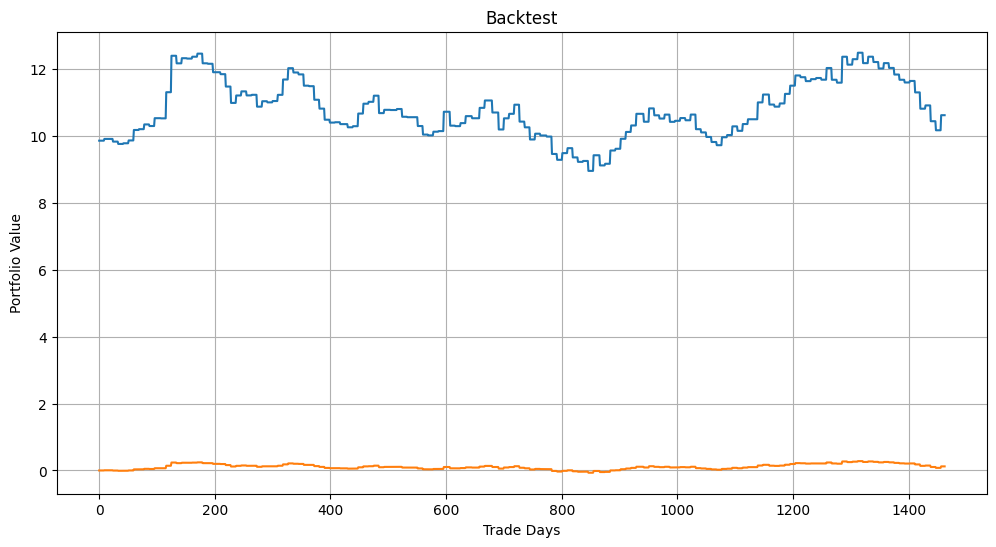

In [30]:
scale_predict = model.predict(x_test)
capital = 10
capital_history = []
open_status = False

count_day = 0

for i in range(taget_date, len(scale_predict) - taget_date):
    today_price = data["Close"]["GC=F"].loc[date[i]]
    future_price = data["Close"]["GC=F"].loc[date[i + taget_date]]
    # t = data["Target"].loc[date[i]]
    day_change = (scale_predict[i] - close[i])
    # day_change = (scale_predict[i] - scale_predict[i-taget_date])

    # print(future_price, t, day_change, today_price, scale_predict[i], scale_predict[i-taget_date])
    if open_status:
        count_day += 1
        if count_day == taget_date:
            open_status = False
        capital_history.append(capital)
        continue
    if abs(day_change) > 0.004:
        open_status = True
        count_day = 0
        capital *= 0.999
        if day_change > 0:
            profit = (future_price - today_price) / today_price * capital
        else:
            profit = (today_price - future_price) / today_price * capital
        # profit_list.append(profit+profit_list[-1])
        capital += profit
        capital *= 0.999
        capital_history.append(capital)
    else:
        capital_history.append(capital)

    capital_history.append(capital)
    # print(day_change, today_price, future_price, scale_predict[i], close[i])
    # break

profit = [0]
for i in range(len(capital_history) - 1):
    profit.append((capital_history[i+1] - capital_history[i]) / capital_history[i] + profit[-1])

# Plot backtest results
plt.figure(figsize=(12, 6))
plt.plot(capital_history)
plt.plot(profit)
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value')
# plt.legend()
plt.grid(True)
plt.show()

In [63]:
len(y_test)

1312

In [64]:
len(scale_predict)

1312

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


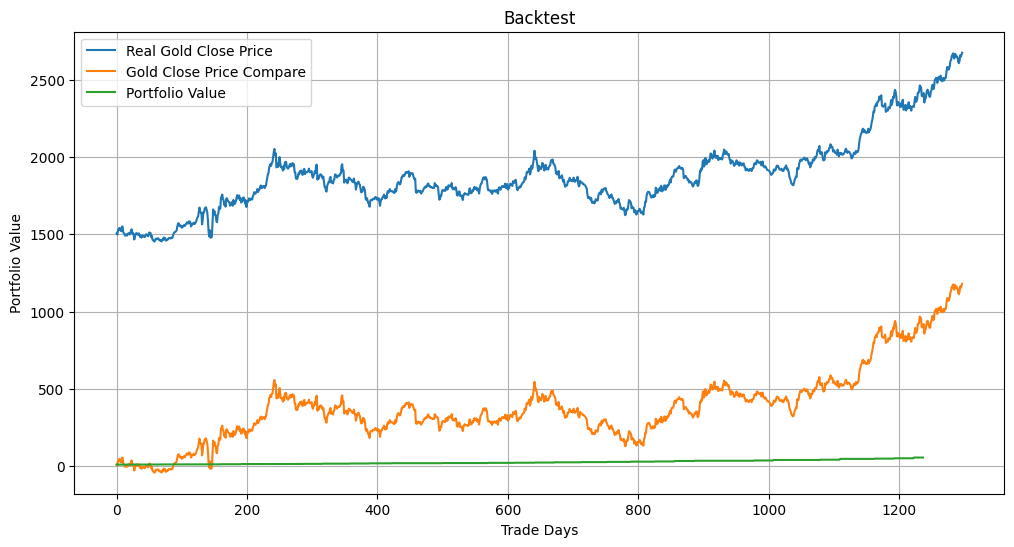

In [ ]:
scale_predict = model.predict(x_test)
capital = 10  # Initial capital
capital_history = []

open_status = False

count_day = 0

for i in range(taget_date, len(y_test) - taget_date):
    today_price = data["Close"]["GC=F"].loc[date[i]]
    future_price = data["Close"]["GC=F"].loc[date[i + taget_date]]
    t = data["Target"].loc[date[i]]
    day_change = (y_test[i]-y_test[i - taget_date])
    # print(future_price, t, day_change, today_price, scale_predict[i], scale_predict[i-taget_date])
    # if open_status:
    #     count_day += 1
    #     if count_day == taget_date-1:
    #         open_status = False
    #     capital_history.append(capital)
    #     continue
    if abs(day_change) > 0.05:
        open_status = True
        count_day = 0
        capital *= 0.999
        if day_change > 0:
            profit = (future_price - today_price) / today_price * capital
        else:
            profit = (today_price - future_price) / today_price * capital
        capital += profit
        capital *= 0.999

    capital_history.append(capital)
    
gold_close_price = data["Close"]
gold_close_price = gold_close_price["GC=F"]
gold_close_price = gold_close_price.loc[date].to_numpy()

# Plot backtest results
plt.figure(figsize=(12, 6))
plt.plot(gold_close_price, label="Real Gold Close Price")
plt.plot((gold_close_price - (gold_close_price[0]-capital_history[0])), label="Gold Close Price Compare")
plt.plot(capital_history, label='Portfolio Value')
# plt.plot(scale_predict[:12], label="pre")
# plt.plot(y_test[:12], label="true")
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

In [854]:
# model = models.load_model("model/simple_lstm_model.h5")

plot graph true close price and predict close price

In [858]:
# model.save(f"model/lstm_36n_v{asset[1]}.h5")

### back test

In [114]:
scale_predict = model.predict(x_test)
capital = 10  # Initial capital
capital_history = []

csv_capital = {
    "date":[],
    "price_today":[],
    "price_next_day":[],
    "scale_day_change":[],
    "capital_befor":[],
    "capital_after":[],
    "profit":[],
    "action":[]
    }

for i in range(len(scale_predict) - 1):
    price_today = data["Close"]["GC=F"].loc[date[i]]
    price_next_day = data["Close"]["GC=F"].loc[date[i+1]]

    day_change = (scale_predict[i+1]-scale_predict[i])[0]
    
    csv_capital["date"].append(date[i])
    csv_capital["price_today"].append(price_today)
    csv_capital["price_next_day"].append(price_next_day)
    csv_capital["scale_day_change"].append(day_change)
    csv_capital["capital_befor"].append(capital)

    if abs(day_change) > 0.002:
        capital *= 0.999
        if day_change > 0:
            csv_capital["action"].append("Long")
            profit = (price_next_day - price_today) / price_today * capital
        else:
            csv_capital["action"].append("Short")
            profit = (price_today - price_next_day) / price_today * capital
        csv_capital["profit"].append(profit)
        capital += profit
        capital *= 0.999
    else:
        csv_capital["profit"].append(0)
        csv_capital["action"].append("None")
    
    csv_capital["capital_after"].append(capital)
    
    capital_history.append(capital)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


save result csv

In [860]:
csv_capital = pd.DataFrame(csv_capital)
csv_capital.to_csv("csv_file/lstm_back_test.csv", index=False)

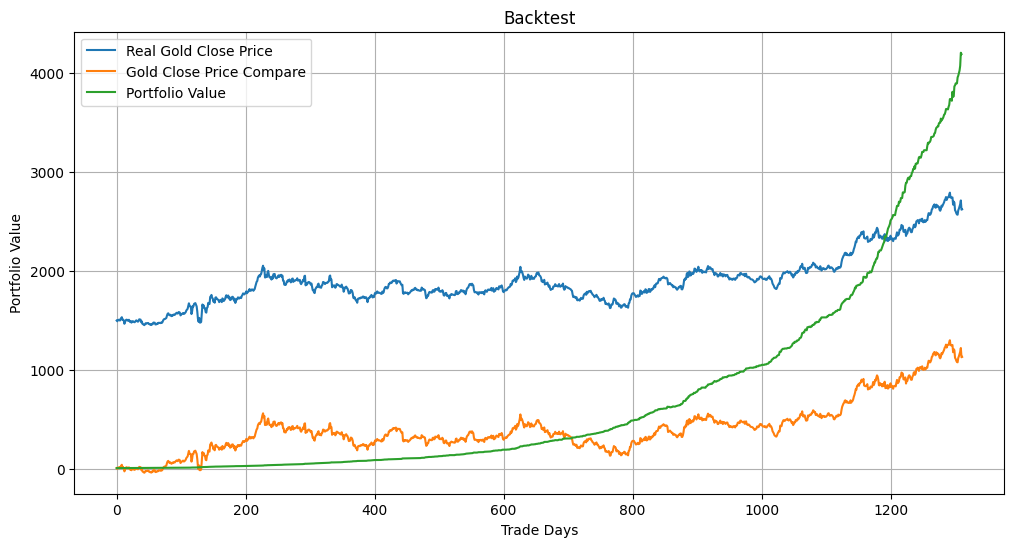

In [115]:
gold_close_price = data["Close"]
gold_close_price = gold_close_price["GC=F"]
gold_close_price = gold_close_price.loc[date].to_numpy()

# Plot backtest results
plt.figure(figsize=(12, 6))
plt.plot(gold_close_price, label="Real Gold Close Price")
plt.plot(gold_close_price - (gold_close_price[0]-capital_history[0]), label="Gold Close Price Compare")
plt.plot(capital_history, label='Portfolio Value')
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

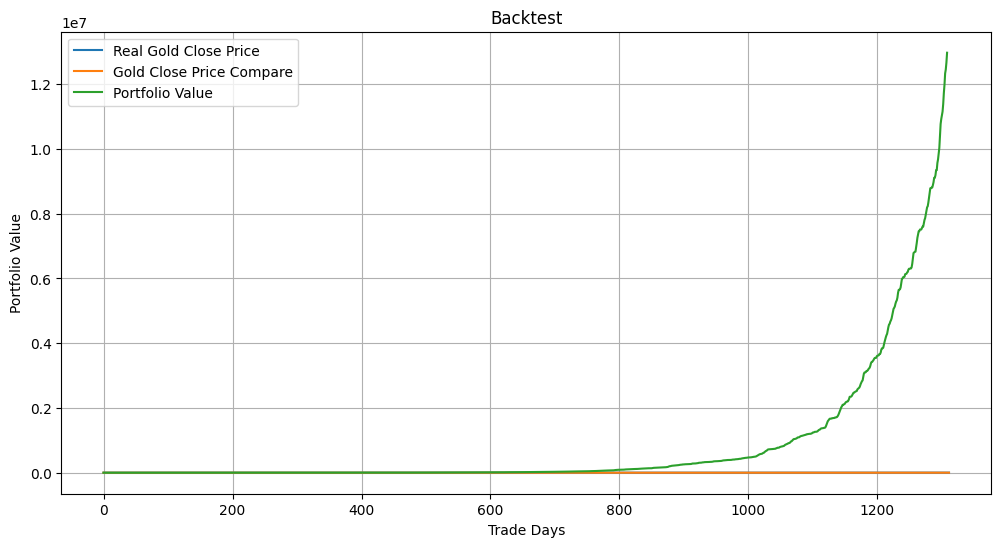

In [21]:
gold_close_price = data["Close"]
gold_close_price = gold_close_price["GC=F"]
gold_close_price = gold_close_price.loc[date].to_numpy()

capital = 10
capital_history = []

for i in range(len(gold_close_price) - 3):
    # print(i)
    price_today = gold_close_price[i]
    price_next_day = gold_close_price[i+3]

    dif = price_next_day - price_today
    dif = dif / price_today

    if abs(dif) > 0.002:
        # i += 7
        capital *= 0.999
        if dif > 0:
            profit = (price_next_day - price_today) / price_today * capital
        else:
            profit = (price_today - price_next_day) / price_today * capital
        capital += profit
        capital *= 0.999
    capital_history.append(capital)

# gold_close_price = data["Close"]
# gold_close_price = gold_close_price["GC=F"]
# gold_close_price = gold_close_price.loc[date].to_numpy()

# Plot backtest results
plt.figure(figsize=(12, 6))
plt.plot(gold_close_price, label="Real Gold Close Price")
plt.plot((gold_close_price - (gold_close_price[0]-capital_history[0])), label="Gold Close Price Compare")
plt.plot(capital_history, label='Portfolio Value')
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

### calculate CAGR , Max Drawdown , SD

In [28]:
import cal_def
import math

cagr = cal_def.cal_cagr(capital_history)
max_dd = cal_def.cal_max_drawdown(capital_history)
sd = cal_def.cal_sd(capital_history) * math.sqrt(250)

print(f"CAGR : {cagr:.3f}")
print(f"Max Drawdown : {max_dd[0]:.3f}")
print(f"\tStart day : {max_dd[1]}\n\tEnd day : {max_dd[2]}")
print(f"SD : {sd:.3f}")

CAGR : 0.013
Max Drawdown : 0.281
	Start day : 177
	End day : 853
SD : 13.868


### evaluate

In [864]:
# model = models.load_model("model/simple_lstm_model_with_volume^GSPC.h5")

scale_predict = model.predict(x_test)

mse = np.mean((y_test-scale_predict.flatten())**2)
rmse = np.sqrt(mse)
mae = np.mean(abs(y_test-scale_predict.flatten()))
print(mse)
print(rmse)
print(mae)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
0.0025594482566029387
0.050590989875697615
0.03156740397490249


In [865]:
tmp = data.loc[date, "Close"]
tmp = tmp["GC=F"].pct_change().to_list()[1:]

- 0 none
- 1 buy
- 2 sell

In [866]:
con_matrix = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

for i in range(len(tmp)):
    action = csv_capital["action"][i]
    if action == "None":
        col = 0
    elif action == "Long":
        col = 1
    else:
        col = 2
    
    real = tmp[i]
    if abs(real) <= 0.002:
        row = 0
    elif real > 0:
        row = 1
    else:
        row = 2
    con_matrix[row][col] += 1
for i in con_matrix:
    print(i)

[133, 88, 60]
[187, 331, 57]
[183, 46, 226]


### all model

In [3]:
import cal_def
import math

cagr = []
max_dd = []
sd = []

[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  2 of 2 completed


(1312, 30, 15) (1312,) (1312, 30, 15) (1312,)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


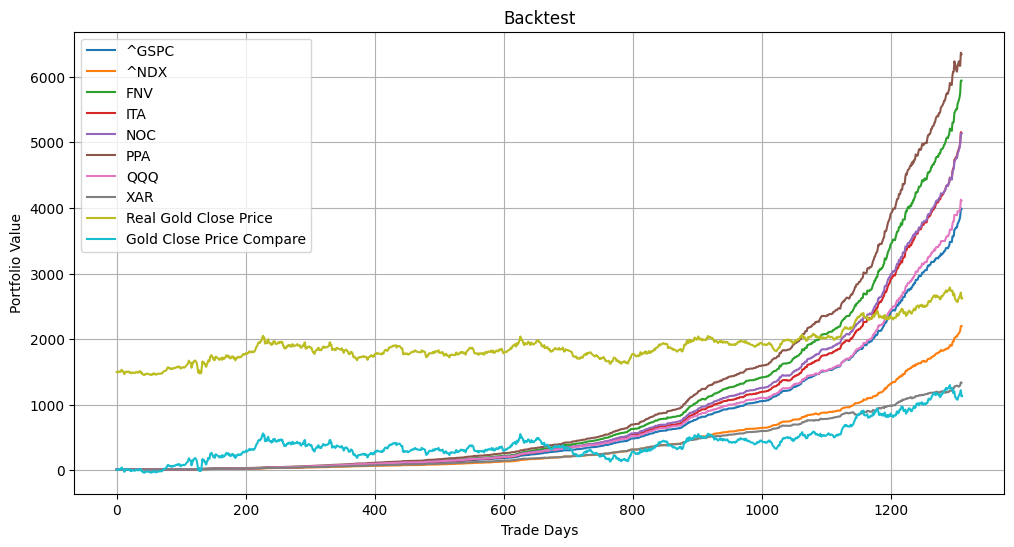

In [4]:
# Plot backtest results
plt.figure(figsize=(12, 6))
plt.title('Backtest')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value')

more_volume = ["^GSPC", "^NDX", "FNV", "ITA", "NOC", "PPA", "QQQ", "XAR"]

for i in more_volume:
    asset = ["GC=F", i]
    data = prepar_data(asset, '2014-01-01', '2024-12-01')
    x_train, y_train, x_test, y_test, date = split_data(data.copy(), data_range=30, train_ratio=0.5)

    model = models.load_model(f"model/lstm_36n_v{i}.h5")
    scale_predict = model.predict(x_test)

    capital = 10
    capital_history = []

    for j in range(len(scale_predict) - 1):
        price_today = data["Close"]["GC=F"].loc[date[j]]
        price_next_day = data["Close"]["GC=F"].loc[date[j+1]]

        day_change = (scale_predict[j+1]-scale_predict[j])[0]
        
        if abs(day_change) > 0.002:
            capital *= 0.999
            if day_change > 0:
                profit = (price_next_day - price_today) / price_today * capital
            else:
                profit = (price_today - price_next_day) / price_today * capital
            capital += profit
            capital *= 0.999
        
        capital_history.append(capital)

    cagr.append(cal_def.cal_cagr(capital_history))
    max_dd.append(cal_def.cal_max_drawdown(capital_history))
    sd.append(cal_def.cal_sd(capital_history) * math.sqrt(250))

    plt.plot(capital_history, label=i)

gold_close_price = data["Close"]
gold_close_price = gold_close_price["GC=F"]
gold_close_price = gold_close_price.loc[date].to_numpy()

plt.plot(gold_close_price, label="Real Gold Close Price")
plt.plot(gold_close_price - (gold_close_price[0]-capital_history[0]), label="Gold Close Price Compare")

plt.legend()
plt.grid(True)
plt.show()

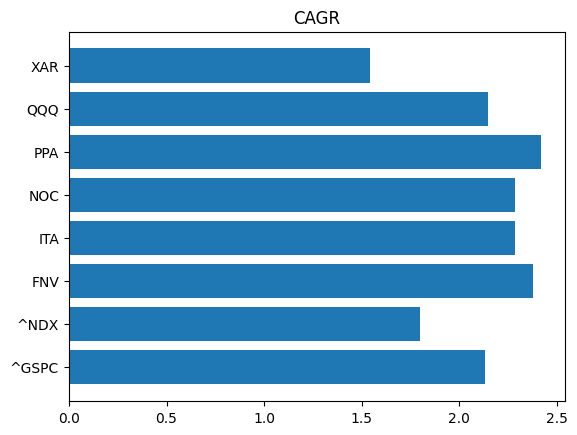

In [5]:
plt.title('CAGR')
plt.barh(more_volume, cagr)
plt.show()

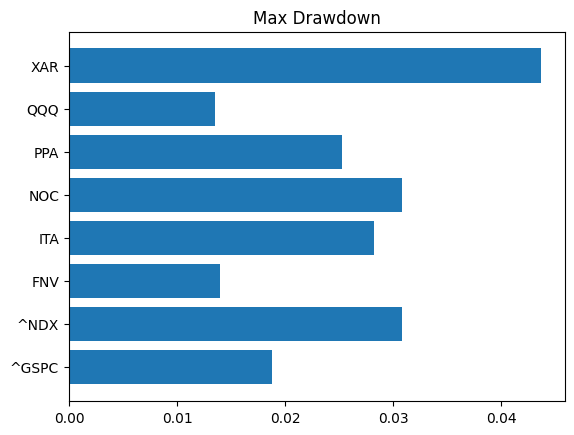

In [6]:
max_dd = [i[0] for i in max_dd]
plt.title('Max Drawdown')
plt.barh(more_volume, max_dd)
plt.show()

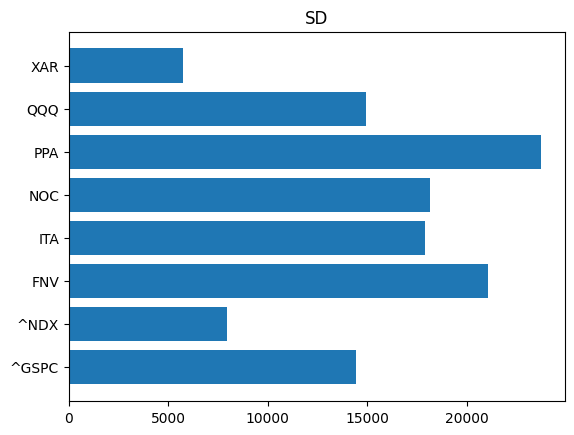

In [7]:
plt.title('SD')
plt.barh(more_volume, sd)
plt.show()